In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from sunpy.net import Fido, attrs as a
import astropy.units as u
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
import numpy as np
from astropy.coordinates import SkyCoord
import sunpy.map
import matplotlib.colors
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from matplotlib import colors

/Users/lilli/Library/Caches/pypoetry/virtualenvs/mflex-cNoQEf_u-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print(Fido)
result = Fido.search(
    a.Time("2024/5/07 07:30:00", "2024/5/07 07:31"),
    a.Instrument.hmi,
    a.Physobs("LOS_magnetic_field"),
)
result

sunpy.net.Fido

Fido is a unified data search and retrieval tool.

It provides simultaneous access to a variety of online data sources, some
cover multiple instruments and data products like the Virtual Solar
Observatory and some are specific to a single source.

For details of using `~sunpy.net.Fido` see :ref:`sunpy-tutorial-acquiring-data-index`.


      Client      ...
----------------- ...
CDAWEBClient      ...
EVEClient         ...
GBMClient         ...
XRSClient         ...
SUVIClient        ...
GONGClient        ...
LYRAClient        ...
NOAAIndicesClient ...
NOAAPredictClient ...
SRSClient         ...
NoRHClient        ...
RHESSIClient      ...
HEKClient         ...
HECClient         ...
JSOCClient        ...
VSOClient         ...


Start Time,End Time,Source,Instrument,Wavelength,Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size
,,,,Angstrom,,,,,,,Mibyte
Time,Time,str3,str3,float64[2],str4,str18,str6,str4,str4,str8,float64
2024-05-07 07:30:35.000,2024-05-07 07:30:36.000,SDO,HMI,6173.0 .. 6174.0,JSOC,LOS_magnetic_field,NARROW,4096,4096,FULLDISK,-0.00098


In [14]:
downloaded_files = Fido.fetch(result)
downloaded_files

Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.33s/file]


['/Users/lilli/sunpy/data/hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram.fits']

In [15]:
path = "/Users/lilli/sunpy/data/hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram.fits"
hmi_image = sunpy.map.Map(path).rotate()
# hmi_image.quicklook()

In [16]:
hdr = hmi_image.fits_header
hdr
# hmi_image.meta

XTENSION= 'IMAGE   '           / binary table extension                         
BITPIX  =                   32 / data type of original image                    
NAXIS   =                    2 / dimension of original image                    
NAXIS1  =                 4102 / length of original image axis                  
NAXIS2  =                 4102 / length of original image axis                  
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
DATE    = '2024-05-11T09:19:35'                                                 
DATE-OBS= '2024-05-07T07:30:35.20'                                              
TELESCOP= 'SDO/HMI '                                                            
INSTRUME= 'HMI_FRONT2'                                                          
WAVELNTH=               6173.0                                                  
CAMERA  =                   

In [18]:
left_corner = SkyCoord(
    Tx=-142 * u.arcsec, Ty=-350 * u.arcsec, frame=hmi_image.coordinate_frame
)
right_corner = SkyCoord(
    Tx=158 * u.arcsec, Ty=-150 * u.arcsec, frame=hmi_image.coordinate_frame
)

hpc_coords = sunpy.map.all_coordinates_from_map(hmi_image)
mask = ~sunpy.map.coordinate_is_on_solar_disk(hpc_coords)
magnetogram_big = sunpy.map.Map(hmi_image.data, hmi_image.meta, mask=mask)

cmap = colors.LinearSegmentedColormap.from_list("", ["black", "white"])

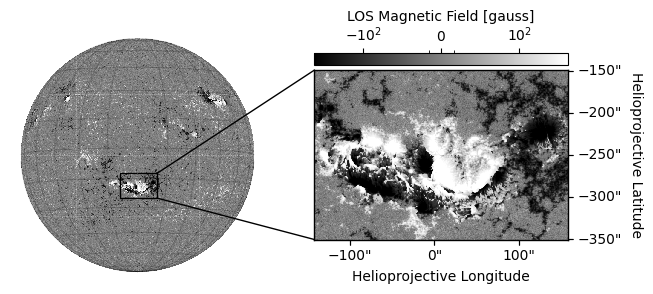

In [19]:
fig = plt.figure(figsize=(7.2, 4.8))
norm = matplotlib.colors.SymLogNorm(50, vmin=-7.5e2, vmax=7.5e2)
ax1 = fig.add_subplot(121, projection=magnetogram_big)
magnetogram_big.plot(
    axes=ax1,
    cmap=cmap,
    norm=norm,
    annotate=False,
)
magnetogram_big.draw_grid(axes=ax1, color="black", alpha=0.25, lw=0.5)

for coord in ax1.coords:
    coord.frame.set_linewidth(0)
    coord.set_ticks_visible(False)
    coord.set_ticklabel_visible(False)

magnetogram_big.draw_quadrangle(
    left_corner, top_right=right_corner, edgecolor="black", lw=1
)
magnetogram_small = hmi_image.submap(left_corner, top_right=right_corner)
ax2 = fig.add_subplot(122, projection=magnetogram_small)
im = magnetogram_small.plot(
    axes=ax2,
    norm=norm,
    cmap=cmap,
    annotate=False,
)
ax2.grid(alpha=0)
lon, lat = ax2.coords[0], ax2.coords[1]
lon.frame.set_linewidth(1)
lat.frame.set_linewidth(1)
lon.set_axislabel(
    "Helioprojective Longitude",
)
lon.set_ticks_position("b")
lat.set_axislabel(
    "Helioprojective Latitude",
)
lat.set_axislabel_position("r")
lat.set_ticks_position("r")
lat.set_ticklabel_position("r")
xpix, ypix = magnetogram_big.wcs.world_to_pixel(right_corner)
con1 = ConnectionPatch(
    (0, 1),
    (xpix, ypix),
    "axes fraction",
    "data",
    axesA=ax2,
    axesB=ax1,
    arrowstyle="-",
    color="black",
    lw=1,
)
xpix, ypix = magnetogram_big.wcs.world_to_pixel(
    SkyCoord(right_corner.Tx, left_corner.Ty, frame=magnetogram_big.coordinate_frame)
)
con2 = ConnectionPatch(
    (0, 0),
    (xpix, ypix),
    "axes fraction",
    "data",
    axesA=ax2,
    axesB=ax1,
    arrowstyle="-",
    color="black",
    lw=1,
)
ax2.add_artist(con1)
ax2.add_artist(con2)

pos = ax2.get_position().get_points()
cax = fig.add_axes([pos[0, 0], pos[1, 1] + 0.01, pos[1, 0] - pos[0, 0], 0.025])
cbar = fig.colorbar(im, cax=cax, orientation="horizontal")
cbar.locator = matplotlib.ticker.FixedLocator([-1e2, 0, 1e2])
cbar.set_label("LOS Magnetic Field [gauss]", labelpad=-40, rotation=0)
cbar.update_ticks()
cbar.ax.xaxis.set_ticks_position("top")
plotname = "/Users/lilli/Desktop/Paper/SDO_07052022.png"
plt.savefig(plotname, dpi=300)
plt.show()

In [20]:
dist = hdr["DSUN_OBS"]
pixelsize_x_unit = hdr["CUNIT1"]
pixelsize_y_unit = hdr["CUNIT2"]
pixelsize_x_arcsec = hdr["CDELT1"]
pixelsize_y_arcsec = hdr["CDELT2"]

In [21]:
if not pixelsize_x_unit == pixelsize_y_unit:
    print("Pixelsize units not matchy-matchy")
    raise ValueError
if not pixelsize_x_arcsec == pixelsize_y_arcsec:
    print("Data pixelsizes in x and y direction not matchy-matchy")
    raise ValueError
else:
    pixelsize_radians = pixelsize_x_arcsec / 206265.0
dist_km = dist / 1000.0
pixelsize_Mm = np.floor(pixelsize_radians * dist_km) * 10**-3

In [22]:
nresol_x = magnetogram_small.data.shape[1]
nresol_y = magnetogram_small.data.shape[0]

xmax_Mm = nresol_x * pixelsize_Mm
ymax_Mm = nresol_y * pixelsize_Mm
pixelsize_z_Mm = 90.0 * 10**-3

zmax_Mm = 20000.0 * 10**-3

xmin = np.float64(0.0)  # Minimum value of x in data length scale, not in Mm
ymin = np.float64(0.0)  # Minimum value of y in data length scale, not in Mm
zmin = np.float64(0.0)  # Minimum value of z in data length scale, not in Mm

nresol_z = int(np.floor(zmax_Mm / pixelsize_z_Mm))

z0 = 2000.0 * 10**-3

nf_max = min(nresol_x, nresol_y)

xmax = xmax_Mm
ymax = ymax_Mm
zmax = zmax_Mm
z0 = z0

pixelsize_x = pixelsize_Mm
pixelsize_y = pixelsize_Mm
pixelsize_z = pixelsize_Mm
print("xmax, ymax, zmax", xmax, ymax, zmax)
print("xmax_Mm, ymax_Mm, zmax_Mm", xmax_Mm, ymax_Mm, zmax_Mm)
print("nresol_x, nresol_y, nresol_z", nresol_x, nresol_y, nresol_z)
print("pixelsize_x, pixelsize_x_Mm", pixelsize_x, pixelsize_Mm)
print("pixelsize_y, pixelsize_y_Mm", pixelsize_y, pixelsize_Mm)
print("pixelsize_z, pixelsize_z_Mm", pixelsize_z, pixelsize_Mm)

xmax, ymax, zmax 219.328 146.464 20.0
xmax_Mm, ymax_Mm, zmax_Mm 219.328 146.464 20.0
nresol_x, nresol_y, nresol_z 596 398 222
pixelsize_x, pixelsize_x_Mm 0.368 0.368
pixelsize_y, pixelsize_y_Mm 0.368 0.368
pixelsize_z, pixelsize_z_Mm 0.368 0.368


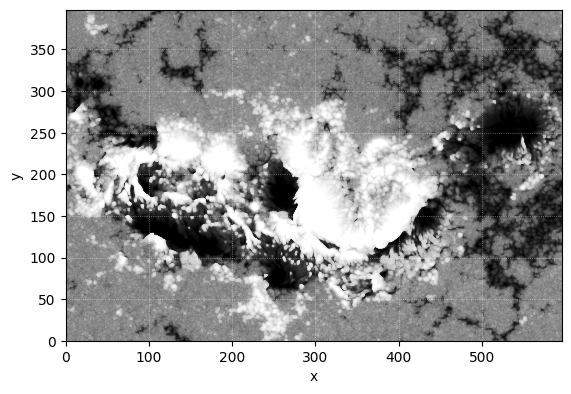

In [23]:
x_arr = np.arange(nresol_x) * (nresol_x) / (nresol_x - 1)
y_arr = np.arange(nresol_y) * (nresol_y) / (nresol_y - 1)
x_plot = np.outer(y_arr, np.ones(nresol_x))
y_plot = np.outer(x_arr, np.ones(nresol_y)).T

fig = plt.figure()
ax = fig.add_subplot(111)
norm = matplotlib.colors.SymLogNorm(50, vmin=-7.5e2, vmax=7.5e2)
ax.grid(color="white", alpha=0.6, linestyle="dotted", linewidth=0.5)
ax.contourf(y_plot, x_plot, magnetogram_small.data, 1000, norm=norm, cmap=cmap)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(ymax / xmax)
plt.show()

In [25]:
from mflex.classes.clsmod import DataBz

data = DataBz(
    magnetogram_small.data,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    pixelsize_z,
    nf_max,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    z0,
)

data_bz = data.data_z
x_arr = np.arange(2 * nresol_x) * (xmax - xmin) / (2 * nresol_x - 1) + xmin
y_arr = np.arange(2 * nresol_y) * (ymax - ymin) / (2 * nresol_y - 1) + ymin
z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

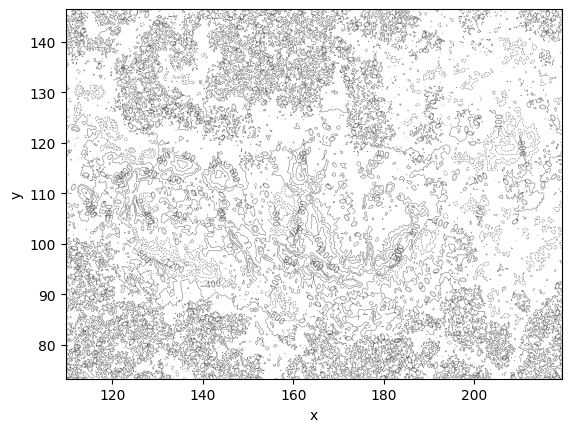

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x],
    y_grid[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x],
    data_bz,
    10,
    colors="k",
    linewidths=0.4,
    alpha=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=6, inline=True)
plt.show()

In [27]:
z0_b = z0
deltaz_b = z0 / 10.0
L = 1.0
# a = 0.2
# alpha = 0.008
b = 1.0

alpha = 0.0025
a = 0.2

length_scale = float(2.0 * L)  # Normalising length scale for Seehafer

length_scale_x = 2.0 * nresol_x * pixelsize_x * L
length_scale_y = 2.0 * nresol_y * pixelsize_y * L

length_scale_x_norm = length_scale_x / length_scale
length_scale_y_norm = length_scale_y / length_scale

kx_arr = np.arange(nf_max) * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(nf_max) * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(nf_max) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2


# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

limit = (k2_arr - (2 * alpha) ** 2) / (2 * k2_arr)

print(limit.min())

0.43907459505331026


In [44]:
from mflex.model.field.bfield_model import magnetic_field

bfield, dpartial_bfield = magnetic_field(
    data_bz,
    z0_b,
    deltaz_b,
    a,
    b,
    alpha,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    nf_max,
    L,
)

length scale 2.0
length scale x 438.656
length scale y 292.928
length scale x norm 219.328
length scale y norm 146.464
xmin, xmax, ymin, ymax, zmin, zmax  0.0 219.328 0.0 146.464 0.0 20.0


KeyboardInterrupt: 

In [ ]:
from mflex.model.field.save import save_field

save_field(
    bfield,
    dpartial_bfield,
    "hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram_mflex_"
    + str(a)
    + "_"
    + str(alpha)
    + "_"
    + str(b),
)

In [15]:
bfield = np.load(
    "/Users/lilli/Desktop/Paper/hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram_mflex_"
    + str(a)
    + "_"
    + str(alpha)
    + "_1.0_bfield3d.npy"
)

dpartial_bfield = np.load(
    "/Users/lilli/Desktop/Paper/hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram_mflex_"
    + str(a)
    + "_"
    + str(alpha)
    + "_1.0_dbzdxdydz3d.npy"
)

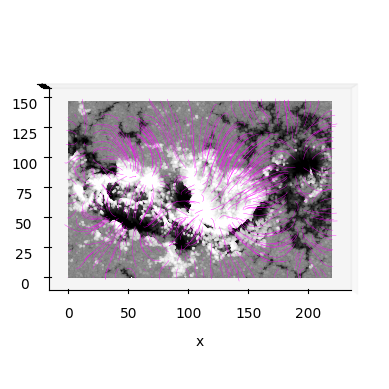

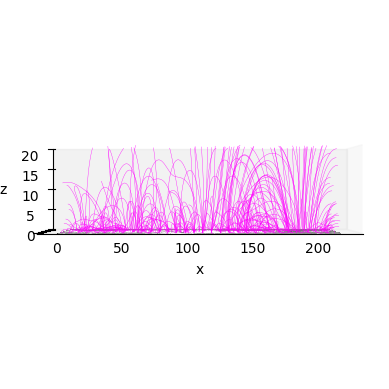

In [16]:
from mflex.plot.plot_magnetogram import plot_fieldlines_sdo_paper

h1 = L / 100.0  # Initial step length for fieldline3D
eps = 1.0e-8
# Tolerance to which we require point on field line known for fieldline3D
hmin = 0.0  # Minimum step length for fieldline3D
hmax = L  # Maximum step length for fieldline3D

plot_fieldlines_sdo_paper(
    bfield,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a,
    b,
    alpha,
    stepsize=7.0,
    view="top",
    cmap=cmap,
)

plot_fieldlines_sdo_paper(
    bfield,
    h1,
    hmin,
    hmax,
    eps,c
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a,
    b,
    alpha,
    stepsize=7.0,
    view="side",
    cmap=cmap,
)

In [28]:
bfield_potential = np.load(
    "/Users/lilli/Desktop/Paper/hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram_mflex_0.0_0.0_1.0_bfield3d.npy"
)

dpartial_bfield_potential = np.load(
    "/Users/lilli/Desktop/Paper/hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram_mflex_0.0_0.0_1.0_dbzdxdydz3d.npy"
)

bfield_lff = np.load(
    "/Users/lilli/Desktop/Paper/hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram_mflex_0.0_0.0025_1.0_bfield3d.npy"
)

dpartial_bfield_lff = np.load(
    "/Users/lilli/Desktop/Paper/hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram_mflex_0.0_0.0025_1.0_dbzdxdydz3d.npy"
)


In [30]:
bfield_mhs = np.load(
    "/Users/lilli/Desktop/Paper/hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram_mflex_0.4_0.0025_1.0_bfield3d.npy"
)

dpartial_bfield_mhs = np.load(
    "/Users/lilli/Desktop/Paper/hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram_mflex_0.4_0.0025_1.0_dbzdxdydz3d.npy"
)

bfield_mhs2 = np.load(
    "/Users/lilli/Desktop/Paper/hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram_mflex_0.2_0.0025_1.0_bfield3d.npy"
)

dpartial_bfield_mhs2 = np.load(
    "/Users/lilli/Desktop/Paper/hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram_mflex_0.2_0.0025_1.0_dbzdxdydz3d.npy"
)

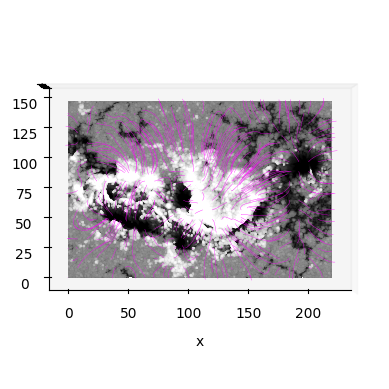

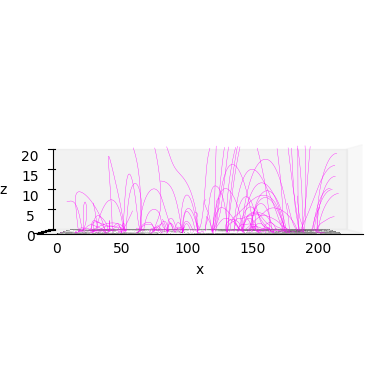

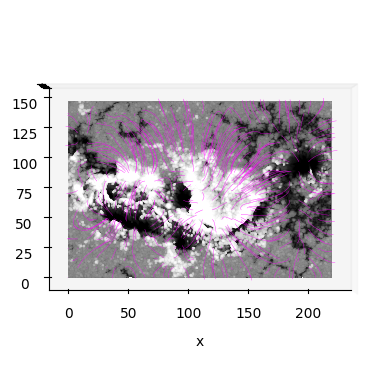

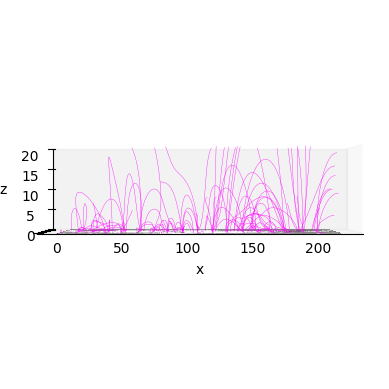

In [31]:
from mflex.plot.plot_magnetogram import plot_fieldlines_sdo_paper, plot_fieldlines_sdo_paper_zoom

L = 1.0
b = 1.0
h1 = L / 100.0  # Initial step length for fieldline3D
eps = 1.0e-8
# Tolerance to which we require point on field line known for fieldline3D
hmin = 0.0  # Minimum step length for fieldline3D
hmax = L  # Maximum step length for fieldline3D

# plot_fieldlines_sdo_paper(
#     bfield_potential,
#     h1,
#     hmin,
#     hmax,
#     eps,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     -xmax,
#     xmax,
#     -ymax,
#     ymax,
#     zmin,
#     zmax,
#     0.0,
#     b,
#     0.0,
#     stepsize=8.0,
#     view="top",
#     cmap=cmap,
# )

# plot_fieldlines_sdo_paper(
#     bfield_potential,
#     h1,
#     hmin,
#     hmax,
#     eps,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     -xmax,
#     xmax,
#     -ymax,
#     ymax,
#     zmin,
#     zmax,
#     0.0,
#     b,
#     0.0,
#     stepsize=12.0,
#     view="side",
#     cmap=cmap,
# )

# plot_fieldlines_sdo_paper(
#     bfield_lff,
#     h1,
#     hmin,
#     hmax,
#     eps,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     -xmax,
#     xmax,
#     -ymax,
#     ymax,
#     zmin,
#     zmax,
#     0.0,
#     b,
#     0.0025,
#     stepsize=8.0,
#     view="top",
#     cmap=cmap,
# )

# plot_fieldlines_sdo_paper(
#     bfield_lff,
#     h1,
#     hmin,
#     hmax,
#     eps,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     -xmax,
#     xmax,
#     -ymax,
#     ymax,
#     zmin,
#     zmax,
#     0.0,
#     b,
#     0.0025,
#     stepsize=12.0,
#     view="side",
#     cmap=cmap,
# )

plot_fieldlines_sdo_paper(
    bfield_mhs2,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    0.2,
    b,
    0.0025,
    stepsize=8.0,
    view="top",
    cmap=cmap,
)

plot_fieldlines_sdo_paper(
    bfield_mhs2,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    0.2,
    b,
    0.0025,
    stepsize=12.0,
    view="side",
    cmap=cmap,
)

plot_fieldlines_sdo_paper(
    bfield_mhs,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    0.4,
    b,
    0.0025,
    stepsize=8.0,
    view="top",
    cmap=cmap,
)

plot_fieldlines_sdo_paper(
    bfield_mhs,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    0.4,
    b,
    0.0025,
    stepsize=12.0,
    view="side",
    cmap=cmap,
)

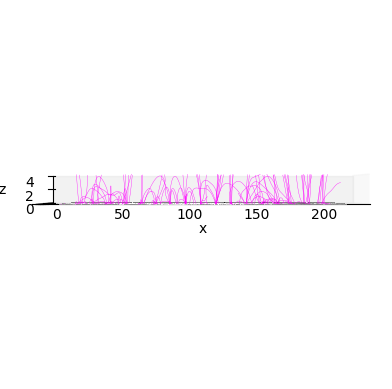

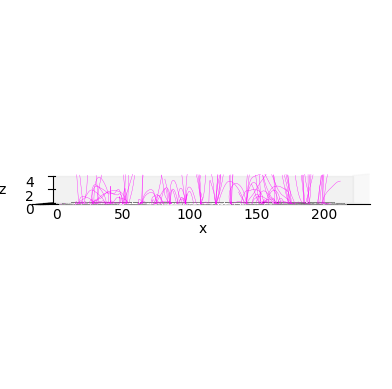

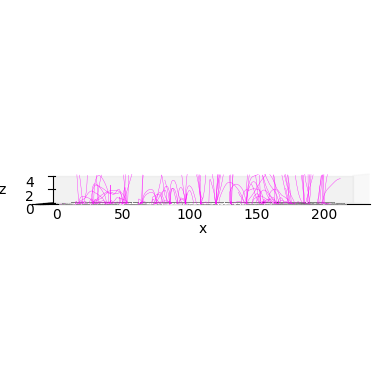

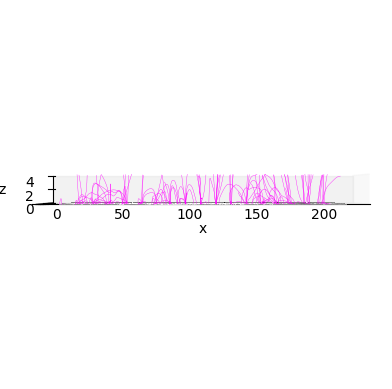

In [42]:
plot_fieldlines_sdo_paper_zoom(
    bfield_potential,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    z0,
    0.0,
    b,
    0.0,
    stepsize=12.0,
    view="side",
    cmap=cmap,
)

plot_fieldlines_sdo_paper_zoom(
    bfield_lff,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    z0,
    0.0,
    b,
    0.0025,
    stepsize=12.0,
    view="side",
    cmap=cmap,
)

plot_fieldlines_sdo_paper_zoom(
    bfield_mhs2,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    z0,
    0.2,
    b,
    0.0025,
    stepsize=12.0,
    view="side",
    cmap=cmap,
)

plot_fieldlines_sdo_paper_zoom(
    bfield_mhs,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    z0,
    0.4,
    b,
    0.0025,
    stepsize=12.0,
    view="side",
    cmap=cmap,
)

In [ ]:
from mflex.model.plasma_parameters import (
    bpressure,
    bdensity,
    btemp,
    deltapres,
    deltaden,
    pres,
    den,
    btemp,
)

# dpres_mhs = np.zeros((nresol_y, nresol_x, nresol_z))
# dden_mhs = np.zeros((nresol_y, nresol_x, nresol_z))


# dpres_lff = np.zeros((nresol_y, nresol_x, nresol_z))
# dden_lff = np.zeros((nresol_y, nresol_x, nresol_z))

# dpres_potential = np.zeros((nresol_y, nresol_x, nresol_z))
# dden_potential = np.zeros((nresol_y, nresol_x, nresol_z))

# for ix in range(nresol_x):
#     for iy in range(nresol_y):
#         for iz in range(nresol_z):
#             z = z_arr[iz]

#             bz_lff = bfield_lff[nresol_y + iy, nresol_x + ix, iz, 2]

#             dbz_lff = (
#                 dpartial_bfield_lff[nresol_y + iy, nresol_x + ix, iz, 1]
#                 * bfield_lff[nresol_y + iy, nresol_x + ix, iz, 1]
#                 + dpartial_bfield_lff[nresol_y + iy, nresol_x + ix, iz, 0]
#                 * bfield_lff[nresol_y + iy, nresol_x + ix, iz, 0]
#                 + dpartial_bfield_lff[nresol_y + iy, nresol_x + ix, iz, 2]
#                 * bfield_lff[nresol_y + iy, nresol_x + ix, iz, 2]
#             )

#             dpres_lff[iy, ix, iz] = deltapres(z, z0_b, deltaz_b, 0.0, b, bz_lff)

#             dden_lff[iy, ix, iz] = deltaden(z, z0_b, deltaz_b, 0.0, b, bz_lff, dbz_lff)

#             bz_mhs = bfield_mhs[nresol_y + iy, nresol_x + ix, iz, 2]

#             dbz_mhs = (
#                 dpartial_bfield_mhs[nresol_y + iy, nresol_x + ix, iz, 1]
#                 * bfield_mhs[nresol_y + iy, nresol_x + ix, iz, 1]
#                 + dpartial_bfield_mhs[nresol_y + iy, nresol_x + ix, iz, 0]
#                 * bfield_mhs[nresol_y + iy, nresol_x + ix, iz, 0]
#                 + dpartial_bfield_mhs[nresol_y + iy, nresol_x + ix, iz, 2]
#                 * bfield_mhs[nresol_y + iy, nresol_x + ix, iz, 2]
#             )

#             dpres_mhs[iy, ix, iz] = deltapres(z, z0_b, deltaz_b, 0.4, b, bz_mhs)

#             dden_mhs[iy, ix, iz] = deltaden(z, z0_b, deltaz_b, 0.4, b, bz_mhs, dbz_mhs)

In [ ]:
dpres_mhs = np.zeros((nresol_y, nresol_x, nresol_z))
dden_mhs = np.zeros((nresol_y, nresol_x, nresol_z))


for ix in range(nresol_x):
    for iy in range(nresol_y):
        for iz in range(nresol_z):
            z = z_arr[iz]

            bz_mhs = bfield_mhs2[nresol_y + iy, nresol_x + ix, iz, 2]

            dbz_mhs = (
                dpartial_bfield_mhs2[nresol_y + iy, nresol_x + ix, iz, 1]
                * bfield_mhs2[nresol_y + iy, nresol_x + ix, iz, 1]
                + dpartial_bfield_mhs2[nresol_y + iy, nresol_x + ix, iz, 0]
                * bfield_mhs2[nresol_y + iy, nresol_x + ix, iz, 0]
                + dpartial_bfield_mhs2[nresol_y + iy, nresol_x + ix, iz, 2]
                * bfield_mhs2[nresol_y + iy, nresol_x + ix, iz, 2]
            )

            dpres_mhs[iy, ix, iz] = deltapres(z, z0_b, deltaz_b, a, b, bz_mhs)

            dden_mhs[iy, ix, iz] = deltaden(z, z0_b, deltaz_b, a, b, bz_mhs, dbz_mhs)

np.save("/Users/lilli/Desktop/Paper/dden_sdo_mhs2", dden_mhs)
np.save("/Users/lilli/Desktop/Paper/dpres_sdo_mhs2", dpres_mhs)

In [ ]:
# np.save("/Users/lilli/Desktop/Paper/dden_sdo_mhs", dden_mhs)
# np.save("/Users/lilli/Desktop/Paper/dpres_sdo_mhs", dpres_mhs)

# np.save("/Users/lilli/Desktop/Paper/dden_sdo_lff", dden_lff)
# np.save("/Users/lilli/Desktop/Paper/dpres_sdo_lff", dpres_lff)

# np.save("/Users/lilli/Desktop/Paper/dden_sdo_potential", dden_potential)
# np.save("/Users/lilli/Desktop/Paper/dpres_sdo_potential", dpres_potential)

dden_mhs = np.load("/Users/lilli/Desktop/Paper/dden_sdo_mhs.npy")
dpres_mhs = np.load("/Users/lilli/Desktop/Paper/dpres_sdo_mhs.npy")

dden_mhs2 = np.load("/Users/lilli/Desktop/Paper/dden_sdo_mhs2.npy")
dpres_mhs2 = np.load("/Users/lilli/Desktop/Paper/dpres_sdo_mhs2.npy")

dden_lff = np.load("/Users/lilli/Desktop/Paper/dden_sdo_lff.npy")
dpres_lff = np.load("/Users/lilli/Desktop/Paper/dpres_sdo_lff.npy")

dden_potential = np.load("/Users/lilli/Desktop/Paper/dden_sdo_potential.npy")
dpres_potential = np.load("/Users/lilli/Desktop/Paper/dpres_sdo_potential.npy")

1992.3949315193438
0.7760709971442223
12257.797736485278
15794.686029488783


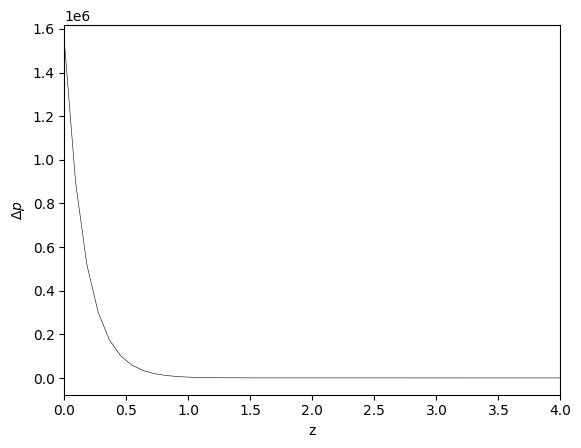

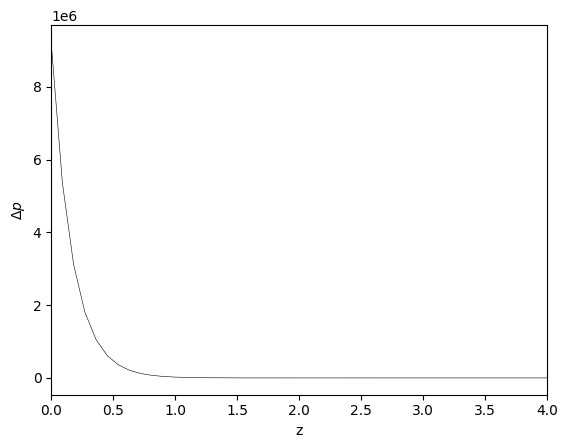

In [ ]:
from mflex.model.plasma_parameters import bpressure, bdensity

z0 = 2.0
deltaz = 0.2
t_photosphere = 5500.0
t_corona = 2.0 * 10.0**6
t0 = (t_photosphere + t_corona * np.tanh(z0 / deltaz)) / (1.0 + np.tanh(z0 / deltaz))
t1 = (t_corona - t_photosphere) / (1.0 + np.tanh(z0 / deltaz))
g_solar = 272.2  # kg/m^3
kB = 1.380649 * 10**-23  # Boltzmann constant in Joule/ Kelvin = kg m^2/(Ks^2)
mbar = 1.67262 * 10**-27  # mean molecular weight (proton mass)
h = (
    kB * t0 / (mbar * g_solar) * 10**-6 / L  # h' = h / L
)  # pressure scale height in normalised length scale (10**-6 to convert to Mm, and L**-1 to convert to normalised length scale)
rho0 = 2.7 * 10**-4  # plasma density at z = 0 in kg/(m^3)
b0 = abs(
    data_bz
).max()  # Gauss background magnetic field strength in 10^-4 kg/(s^2A) = 10^-4 T
p0 = t_photosphere * kB * rho0 / mbar  # plasma pressure in kg/(s^2 m)
mu0 = 1.25663706 * 10**-6  # permeability of free space in mkg/(s^2A^2)
pB0 = (b0 * 10**-4) ** 2 / (2 * mu0)  # magnetic pressure b0**2 / 2mu0 in kg/(s^2m)
beta0 = p0 / pB0  # Plasma Beta, ration plasma to magnetic pressure
# h_photo = h / t0 * t_photosphere

print(b0)
print(beta0)

print(p0)
print(pB0)

backpres = 0.0 * z_arr
backden = 0.0 * z_arr

for iz in range(nresol_z):
    z = z_arr[iz]
    backpres[iz] = bpressure(z, z0, deltaz, h, t0, t1)
    backden[iz] = bdensity(z, z0, deltaz, h, t0, t1)

plt.plot(
    z_arr,
    0.5 * beta0 * backpres * b0**2.0,
    linewidth=0.4,
    linestyle="solid",
    color="black",
)
plt.xlim([0, 2 * z0])
plt.ylabel(r"$\Delta p$")
plt.xlabel("z")
plt.show()

plt.plot(
    z_arr,
    0.5 * beta0 / h * t0 / t_photosphere * backden * b0**2.0,
    linewidth=0.4,
    linestyle="solid",
    color="black",
)
plt.xlim([0, 2 * z0])
plt.ylabel(r"$\Delta p$")
plt.xlabel("z")
plt.show()

(0, 0, 65)
(147, 306, 0)


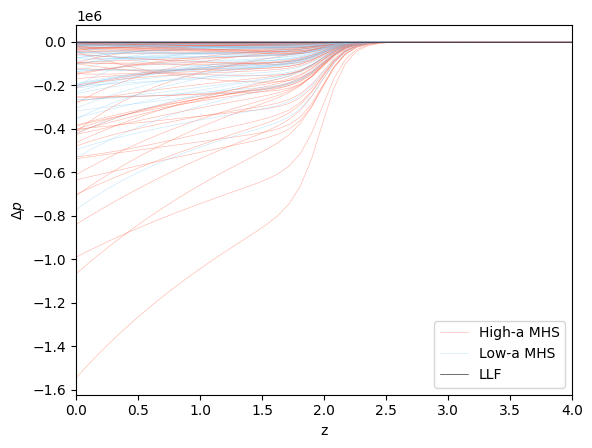

(159, 283, 0)
(160, 278, 0)


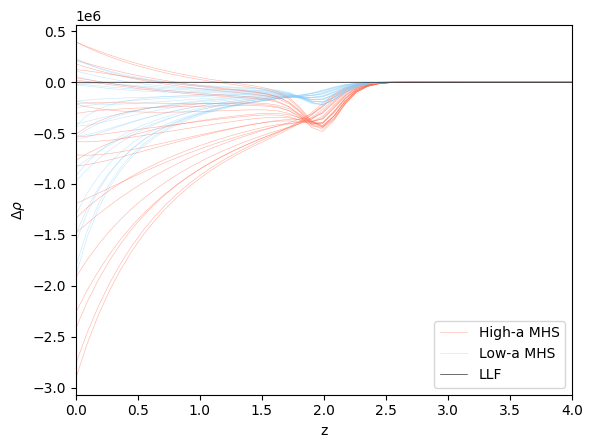

In [ ]:
ix_max = np.unravel_index(data_bz.argmax(), data_bz.shape)[1]
iy_max = np.unravel_index(data_bz.argmax(), data_bz.shape)[0]
print(np.unravel_index(dpres_mhs.argmax(), dpres_mhs.shape))
print(np.unravel_index(dpres_mhs.argmin(), dpres_mhs.shape))

plt.plot(
    z_arr,
    dpres_mhs[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color="tomato",
    alpha=0.5,
    label="High-a MHS",
)
plt.plot(
    z_arr,
    dpres_mhs2[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color="lightskyblue",
    alpha=0.5,
    label="Low-a MHS",
)
for ix in range(120, 307, 6):
    for iy in range(123, 148, 12):
        plt.plot(
            z_arr,
            dpres_mhs[iy, ix, :],
            linewidth=0.4,
            linestyle="solid",
            color="tomato",
            alpha=0.5,
        )
        plt.plot(
            z_arr,
            dpres_mhs2[iy, ix, :],
            linewidth=0.4,
            linestyle="solid",
            color="lightskyblue",
            alpha=0.5,
        )
plt.plot(
    z_arr,
    dpres_lff[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color="black",
    label="LLF",
)
plt.xlim([0, 2 * z0])
plt.ylabel(r"$\Delta p$")
plt.xlabel("z")
plt.legend()
plotname = "/Users/lilli/Desktop/Paper/SDO_dpres.png"
plt.savefig(plotname, dpi=300)
plt.show()

print(np.unravel_index(dden_mhs.argmax(), dden_mhs.shape))
print(np.unravel_index(dden_mhs.argmin(), dden_mhs.shape))


plt.plot(
    z_arr,
    dden_mhs[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color="tomato",
    alpha=0.5,
    label="High-a MHS",
)
plt.plot(
    z_arr,
    dden_mhs2[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color="lightskyblue",
    alpha=0.5,
    label="Low-a MHS",
)
for ix in [278, 279, 280, 281, 282, 283]:
    for iy in [158, 159, 160, 161]:
        plt.plot(
            z_arr,
            dden_mhs[iy, ix, :],
            linewidth=0.4,
            linestyle="solid",
            color="tomato",
            alpha=0.5,
        )
        plt.plot(
            z_arr,
            dden_mhs2[iy, ix, :],
            linewidth=0.4,
            linestyle="solid",
            color="lightskyblue",
            alpha=0.5,
        )
plt.plot(
    z_arr,
    dden_lff[iy_max, ix_max, :],
    linewidth=0.4,
    linestyle="solid",
    color="black",
    label="LLF",
)
plt.xlim([0, 2 * z0])
plt.ylabel(r"$\Delta \rho$")
plt.xlabel("z")
plt.legend()
plotname = "/Users/lilli/Desktop/Paper/SDO_dden.png"
plt.savefig(plotname, dpi=300)
plt.show()

In [ ]:
for ix in range(nresol_x):
    for iy in range(nresol_y):
        plt.plot(
            z_arr,
            (0.5 * beta0 * backpres[:] * b0**2.0 + dpres_mhs[iy, ix, :]) / mu0 * 10**-8,
            linewidth=0.4,
            linestyle="dashed",
            color="black",
            alpha=0.5,
        )
plt.xlim([0, 2 * z0])
plt.ylabel(r"$\Delta p$")
plt.xlabel("z")
plt.show()

for ix in range(nresol_x):
    for iy in range(nresol_y):
        plt.plot(
            z_arr,
            (
                0.5 * beta0 / h * t0 / t_photosphere * backden[:] * b0**2.0
                + dden_mhs[iy, ix, :]
            )
            / (mu0 * g_solar * L)
            * 10**-14,
            linewidth=0.4,
            linestyle="dashed",
            color="black",
            alpha=0.5,
        )
plt.xlim([0, 2 * z0])
plt.ylabel(r"$\Delta \rho$")
plt.xlabel("z")
plt.show()

In [ ]:
print(np.unravel_index(dden_mhs.argmax(), dden_mhs.shape))
print(np.unravel_index(dden_mhs.argmin(), dden_mhs.shape))
print(dpres_mhs.min())
print(np.unravel_index(dpres_mhs.argmax(), dpres_mhs.shape))
print(np.unravel_index(dpres_mhs.argmin(), dpres_mhs.shape))
print(dden_mhs.min())

In [ ]:
p = 0.0 * dpres_mhs
d = 0.0 * dden_mhs

In [ ]:
for ix in range(nresol_x):
    for iy in range(nresol_y):
        p[iy, ix, :] = (
            (0.5 * beta0 * backpres[:] * b0**2.0 + dpres_mhs[iy, ix, :]) / mu0 * 10**-8
        )
        d[iy, ix, :] = (
            (
                0.5 * beta0 / h * t0 / t_photosphere * backden[:] * b0**2.0
                + dden_mhs[iy, ix, :]
            )
            / (mu0 * g_solar * L)
            * 10**-14
        )

In [ ]:
p.min()

In [ ]:
d.min()